In [1]:
import knapsack as knap
import ast
import timeit
import time
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from functools import partial

In [2]:
%matplotlib inline

## The Data

In [3]:
def read_all_instances():
    instances = dict()
    for filename in glob.iglob('data/knap_??.inst.dat'):
        with open(filename) as f:
            instances.update(knap.read_instances(f))

    return pd.DataFrame.from_dict(instances, orient='index')

In [4]:
def read_solutions(f):
    data = {}
    for line in f.readlines():
        items = list(map(int, line.split()))
        data[items[0]] = {
            'solution_value': items[2],
            'solution': items[3:]
        }
    return data

In [5]:
def read_all_solutions():
    solutions = dict()
    for filename in glob.iglob('data/knap_??.sol.dat'):
        with open(filename) as f:
            solutions.update(read_solutions(f))
    return pd.DataFrame.from_dict(solutions, orient='index')

In [6]:
# df = pd.concat([inst_df, sol_df], axis=1)

In [7]:
def backup_dataframe():
    # save DataFrame
    df.to_csv('data/dataframe-backup.csv')

In [8]:
# restore DataFrame
generic = lambda x: ast.literal_eval(x)
converters = {
    'weights': generic,
    'values': generic,
    'solution': generic
}
df = pd.read_csv('data/dataframe-backup.csv', index_col=0, converters=converters)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600 entries, 9000 to 9599
Data columns (total 10 columns):
n                   600 non-null int64
m                   600 non-null int64
weights             600 non-null object
values              600 non-null object
heuristic_time      600 non-null float64
brute_force_time    300 non-null float64
solution_value      600 non-null int64
solution            600 non-null object
heuristic_value     600 non-null float64
relative_error      600 non-null float64
dtypes: float64(4), int64(3), object(3)
memory usage: 51.6+ KB


,n,m,weights,values,heuristic_time,brute_force_time,solution_value,solution,heuristic_value,relative_error
9000,4,100,"[18, 42, 88, 3]","[114, 136, 192, 223]",0.000037,0.000055,473,"[1, 1, 0, 1]",473.0,0.000000
9001,4,100,"[55, 81, 14, 52]","[29, 64, 104, 222]",0.000030,0.000055,326,"[0, 0, 1, 1]",326.0,0.000000
9002,4,100,"[89, 18, 57, 69]","[196, 62, 34, 112]",0.000027,0.000051,196,"[1, 0, 0, 0]",174.0,0.112245
9003,4,100,"[34, 23, 62, 2]","[169, 152, 44, 224]",0.000029,0.000059,545,"[1, 1, 0, 1]",545.0,0.000000
9004,4,100,"[67, 74, 87, 65]","[145, 111, 139, 243]",0.000023,0.000061,243,"[0, 0, 0, 1]",243.0,0.000000


In [9]:
ns = [4, 10, 15, 20, 22, 25, 27, 30, 32, 35, 37, 40]

In [10]:
def time_instances(fn, ns, df, time_column):
    for n in ns:
        for idx, inst in df[df['n'] == n].iterrows():
            global inst_fn  # TODO global allows to make import from __main__
            inst_fn = partial(fn, *inst[['n', 'm', 'weights', 'values']])
            timer = timeit.Timer('inst_fn()', setup='from __main__ import inst_fn', timer=time.process_time)
            t = timer.timeit(number=1)
            df.loc[idx, time_column] = t
            print(idx, inst['n'], t)

## Brute Force

In [11]:
time_instances(knap.brute_force, [], df, 'brute_force_time')

## Heuristic

In [12]:
time_instances(knap.heuristic, [], df, 'heuristic_time')

In [13]:
def solve_instances(fn, ns, df, solution_column):
    for n in ns:
        for idx, inst in df[df['n'] == n].iterrows():
            value, _ = fn(*inst[['n', 'm', 'weights', 'values']])
            df.loc[idx, solution_column] = value
            print(idx, inst['n'], value)

In [14]:
solve_instances(knap.heuristic, [], df, 'heuristic_value')

## Relative Error

In [15]:
df['relative_error'] = (df['solution_value'] - df['heuristic_value']) / df['solution_value']

In [16]:
group = df.groupby(by='n')['relative_error']
mean_error = group.mean()
max_error = group.max()

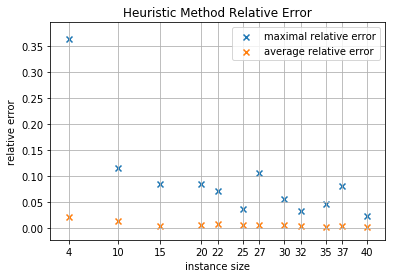

In [17]:
ax = plt.subplot()
ax.set_title('Heuristic Method Relative Error')
ax.scatter(ns, max_error, marker='x', label='maximal relative error')
ax.scatter(ns, mean_error, marker='x', label='average relative error')
ax.set_xticks(ns)
ax.set_ylabel('relative error')
ax.set_xlabel('instance size')
ax.legend()
ax.grid()

plt.savefig('reports/img/heuristic_relative_error.pdf')

## Time Plot

In [18]:
times = df.groupby(by='n')[['brute_force_time', 'heuristic_time']].mean()
times

,brute_force_time,heuristic_time
n,,
4,0.000038,0.000026
10,0.002232,0.000027
15,0.102152,0.000035
20,3.788610,0.000044
22,16.176022,0.000058
25,138.542621,0.000064
27,NaN,0.000055
30,NaN,0.000059
32,NaN,0.000070


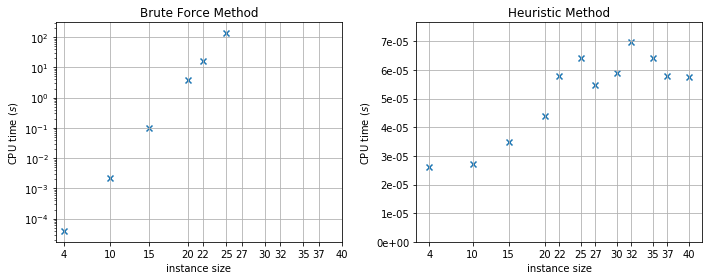

In [19]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
# brute force
ax1.set_yscale('log')
ax1.scatter(ns, times['brute_force_time'], marker='x')
ax1.set_title('Brute Force Method')
ax1.set_xticks(ns)
ax1.set_xlabel('instance size')
ax1.set_ylabel('CPU time ($s$)')
ax1.grid()

# heuristic
ax2.scatter(ns, times['heuristic_time'], marker='x')
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.e'))
ax2.set_ylim([0, 1.1 * times['heuristic_time'].max()])
ax2.set_title('Heuristic Method')
ax2.set_xticks(ns)
ax2.set_xlabel('instance size')
ax2.set_ylabel('CPU time ($s$)')
ax2.grid()

fig.tight_layout()
plt.savefig('reports/img/brute_force_heuristic_times.pdf')